In [ ]:
import requests
import pandas as pd

# Example URL for NOAA NDBC API
url = 'https://www.ndbc.noaa.gov/data/realtime2/41001.txt'
response = requests.get(url)
data = response.text

# Convert the data into a DataFrame
df = pd.read_csv(url, delim_whitespace=True, header=[0,1])
print(df)

       #YY MM  DD hh  mm WDIR WSPD  GST WVHT DPD  APD  MWD    PRES  ATMP  \
       #yr mo  dy hr  mn degT  m/s  m/s    m sec  sec degT     hPa  degC   
0     2024  8  17  6  10   40  6.0  8.0  2.3  MM  7.3  116  1015.7  26.4   
1     2024  8  17  6   0   40  7.0  8.0   MM  MM   MM   MM  1015.7  26.4   
2     2024  8  17  5  50   40  7.0  8.0  2.1  14  7.2  137  1015.9  26.4   
3     2024  8  17  5  40   50  6.0  8.0   MM  MM   MM   MM  1015.8  26.4   
4     2024  8  17  5  30   50  6.0  8.0   MM  MM   MM   MM  1015.9  26.4   
...    ... ..  .. ..  ..  ...  ...  ...  ...  ..  ...  ...     ...   ...   
6460  2024  7   3  0  40   50  6.0  8.0  1.2  MM  4.7   35  1021.9  25.3   
6461  2024  7   3  0  30   50  7.0  9.0   MM  MM   MM   MM  1021.8  25.3   
6462  2024  7   3  0  20   50  7.0  9.0  1.2   7  4.6   39  1021.8  25.2   
6463  2024  7   3  0  10   50  7.0  8.0  1.2  MM  4.6   39  1021.7  25.3   
6464  2024  7   3  0   0   50  7.0  8.0   MM  MM   MM   MM  1021.7  25.3   

      WTMP 

In [ ]:
# Construct datetime from MultiIndex columns
df['datetime'] = pd.to_datetime(df[('#YY', '#yr')].astype(str) + '-' +
                                 df[('MM', 'mo')].astype(str) + '-' +
                                 df[('DD', 'dy')].astype(str) + ' ' +
                                 df[('hh', 'hr')].astype(str) + ':' +
                                 df[('mm', 'mn')].astype(str))

df = df.set_index('datetime')

# Assuming 'WTMP' is your sea surface temperature column
df['SST'] = df[('WTMP', 'degC')]  # Adjust the second level index if needed
print(df['SST'].dtype)

object


<Axes: xlabel='datetime'>

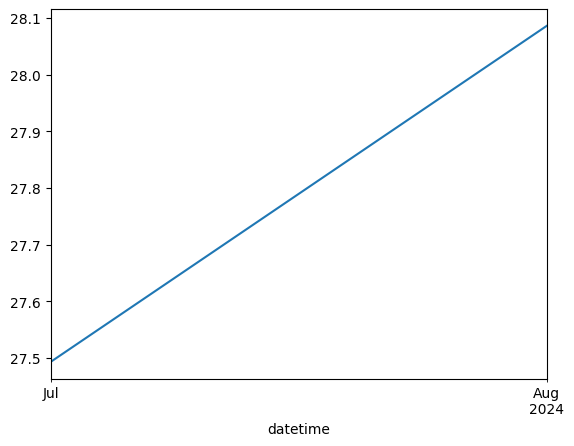

In [ ]:
# Convert 'SST' column to numeric, handling non-convertible values
df['SST'] = pd.to_numeric(df['SST'], errors='coerce')

# Calculate monthly average SST
SST_Monthly_Avg = df['SST'].resample('M').mean()

# Plot the monthly averages
SST_Monthly_Avg.plot()

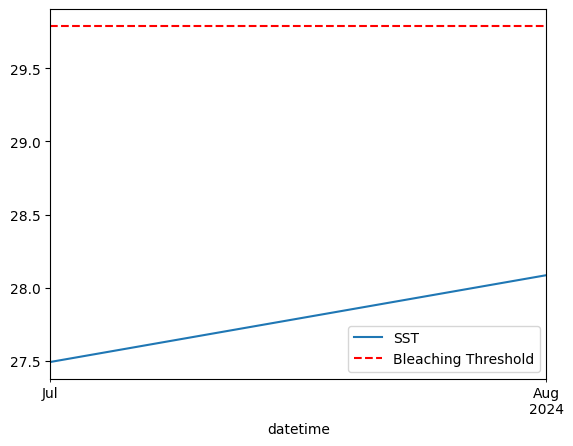

In [ ]:
import matplotlib.pyplot as plt
# Calculate monthly average SST (already done in previous step)
SST_Monthly_Avg = df['SST'].resample('M').mean()

# Calculate threshold
threshold = SST_Monthly_Avg.mean() + 2

# Plot monthly averages (already done in previous step)
SST_Monthly_Avg.plot()

# Add threshold line to the plot
plt.axhline(y=threshold, color='r', linestyle='--', label='Bleaching Threshold')
plt.legend()  # Show the legend
plt.show()    # Display the plot

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Assuming df is already defined and SST data is cleaned

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
df = df.copy()

# Resample the data to daily average first
df['SST_Daily_Avg'] = df['SST'].resample('D').mean()

# Then resample the daily average to monthly average
df['SST_Monthly_Avg'] = df['SST_Daily_Avg'].resample('M').mean()

# Continue with the rest of your analysis as before
print("Columns in DataFrame:", df.columns)
print(df[[('SST_Monthly_Avg', '')]].dropna().head())
df = df.dropna(subset=[('SST_Monthly_Avg', '')])

X = df.index.factorize()[0].reshape(-1, 1)
y = df[('SST_Monthly_Avg', '')].values

model = LinearRegression()
model.fit(X, y)

future_X = [[i] for i in range(len(X), len(X) + 12)]
future_predictions = model.predict(future_X)

print(future_predictions)


Columns in DataFrame: MultiIndex([(            '#YY',  '#yr'),
            (             'MM',   'mo'),
            (             'DD',   'dy'),
            (             'hh',   'hr'),
            (             'mm',   'mn'),
            (           'WDIR', 'degT'),
            (           'WSPD',  'm/s'),
            (            'GST',  'm/s'),
            (           'WVHT',    'm'),
            (            'DPD',  'sec'),
            (            'APD',  'sec'),
            (            'MWD', 'degT'),
            (           'PRES',  'hPa'),
            (           'ATMP', 'degC'),
            (           'WTMP', 'degC'),
            (           'DEWP', 'degC'),
            (            'VIS',  'nmi'),
            (           'PTDY',  'hPa'),
            (           'TIDE',   'ft'),
            (            'SST',     ''),
            ('SST_Monthly_Avg',     ''),
            (  'SST_Daily_Avg',     '')],
           )
           SST_Monthly_Avg
                          
datetime

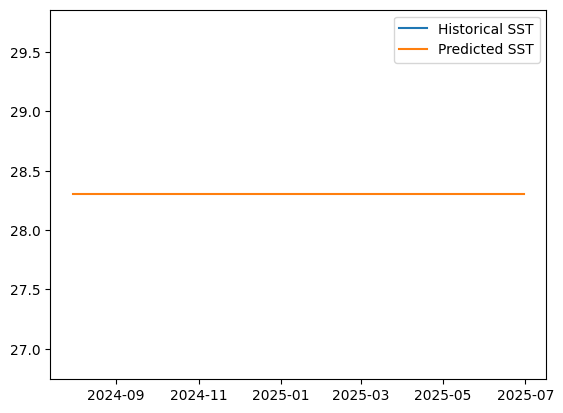

In [ ]:
plt.plot(df.index, df['SST_Monthly_Avg'], label='Historical SST')
plt.plot(pd.date_range(start=df.index[-1], periods=12, freq='M'), future_predictions, label='Predicted SST')
plt.legend()
plt.show()
